[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/14thApostle/ME6324-Steel-Defect-segmentation/blob/main/unet_inference.ipynb)

In [120]:
import pdb
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Normalize, Compose)
from albumentations.pytorch import ToTensor
import torch.utils.data as data
import matplotlib.pyplot as plt

from segmentation_models_pytorch import Unet

In [132]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples
    
def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """

    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv2.findContours(mask_layer, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = cv2.drawContours(image, contours, -1, color, 2)
        
    return image

def visualise_mask(img_path, mask):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """
    
    # reading in the image
    image = cv2.imread(img_path)

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    for index in range(mask.shape[-1]):
        
        # indeces are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
        label = index + 1
        
        # add the contours, layer per layer 
        image = mask_to_contours(image, mask[:,:,index], color=palette[label])   
        
    return image

In [128]:
""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

In [150]:
# initialize test dataloader
best_threshold = 0.2
min_size = 700

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
test_transform = Compose(
    [
        Normalize(mean=mean, std=std, p=1),
        ToTensor(),
    ]
)
def preprocess_input(img_path, transform):
    image = cv2.imread(img_path)
    images = transform(image=image)["image"]
    return images

def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [151]:
# Initialize mode and load trained weights
ckpt_path = "./model_2nd_unet_60epochs.pth"
device = torch.device("cuda")
model = Unet("resnet18", encoder_weights=None, classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [162]:
img_path = "./severstal-steel-defect-detection/train_images/97bf2a97c.jpg"
img = preprocess_input(img_path, test_transform)
img = img.unsqueeze(0)
img = img.to(device)

In [163]:
preds = torch.sigmoid(model(img))
preds = preds.detach().cpu().numpy()
print("input", img.shape)
print("output",preds.shape)

input torch.Size([1, 3, 256, 1600])
output (1, 4, 256, 1600)


In [164]:
predictions = []
final_mask = []
for cls, pred in enumerate(preds[0]):
    pred, num = post_process(pred, best_threshold, min_size)
    final_mask.append(pred)
    name = os.path.basename(img_path) + f"_{cls+1}"
    predictions.append([name, pred])
final_mask = np.array(final_mask)
final_mask = np.transpose(final_mask, (1,2, 0)).astype(np.uint8)
print(final_mask.shape)
print(np.unique(final_mask, return_counts = True))

(256, 1600, 4)
(array([0, 1], dtype=uint8), array([1630362,    8038]))


In [165]:
final_img = visualise_mask(img_path=img_path, mask=final_mask)

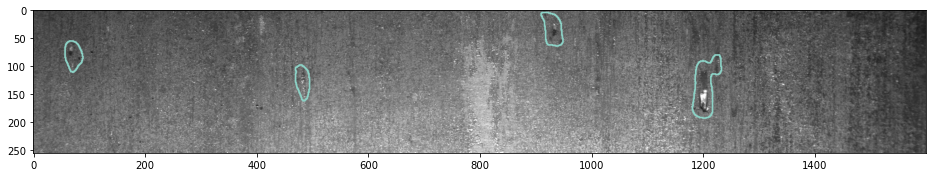

In [166]:
plt.figure(figsize = (16, 3))
plt.imshow(final_img)